# Imports & Load Data

In [99]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

# Prepare Dataset

In [126]:
import gzip, pickle
with gzip.open("mnist_2_vs_9.gz") as f:
    data = pickle.load(f, encoding="bytes")
    Xtrain, Ytrain, Xtest, Ytest, Xdev, Ydev = \
        data[b"Xtrain"], data[b"Ytrain"], data[b"Xtest"], \
        data[b"Ytest"], data[b"Xdev"], data[b"Ydev"]

# Preparing Training Dataset
Xtrain = torch.tensor(Xtrain)
Ytrain = torch.tensor(Ytrain)
train = torch.utils.data.TensorDataset(Xtrain, Ytrain)
train_loader = DataLoader(train, batch_size = 64, shuffle = False)

# Preparing Validation Dataset
Xdev = torch.tensor(Xdev)
Ydev = torch.tensor(Ydev)
dev = torch.utils.data.TensorDataset(Xdev, Ydev)
dev_loader = DataLoader(dev, batch_size = 64, shuffle = False)

# Preparing Test Dataset
Xtest = torch.tensor(Xtest)
Ytest = torch.tensor(Ytest)
test = torch.utils.data.TensorDataset(Xtest, Ytest)
test_loader = DataLoader(test, batch_size=64 ,shuffle = False)


# train_loader is like a dictionary like this:
# [ 
#   [batch 1 : [features, labels] ] 
#   [batch 2 : [features, labels] ] 
#   [etc.,                        ] ]

# Define Network

In [127]:
# Define Class Network for ANN
class Network(nn.Module):
	
	def __init__(self):
		super(Network, self).__init__()
		self.fc1 = nn.Linear(784, 100) # 784 input neurons to 100 hidden neurons.
		self.fc2 = nn.Linear(100, 2) # 100 hidden neurons to 2 output neurons.
		self.drop = nn.Dropout(p=0.5) # probability that a neuron will be zeroed.

	def forward(self, x):
		x = self.fc1(x) # linear transformation of input layer.
		x = self.drop(x) # drop neurons at random. (useful for regularization in case of many layers)
		x = torch.sigmoid(x) # Activation of input layer.
		x = self.fc2(x) # linear transformation of hidden-layer to output.
		return x

# Initialize Network Object
model = Network()

# Loss Object
error = nn.CrossEntropyLoss()

learning_rate = 0.002
epochs = 100 # cycles of forward & backprop.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the Network

In [128]:
training_loss = []
validation_loss = []
train_zero_one = []
val_zero_one = []
iterations = []
count=0

for epoch in range(epochs):

    # Training will run for epoch = 100 cycles.
    # Each cycle consists of all batches in the training set.
    # For each batch, we perform forward and back propagation to compute loss and update parameters.
    
    train_batch_loss = []
    correct = 0
    total = 0
    
    for i, (features, labels) in enumerate(train_loader):
    
        '''     i                         -> Batch number
                features                  -> Training features
                labels                    -> Training labels.
                train_loader              -> Tensor dataset with all batches.
                epochs                    -> 100
                batch_size                -> 64
                number of batches         -> 155
                Total training examples   -> 9956
                Model                     -> ANN with 1 hidden layer(s).
                Activation                -> Sigmoid.
                LOSS                      -> Cross Entropy Loss Function.
                Learning_rate             -> 0.001                          '''
        
        # clear gradients
        optimizer.zero_grad()
    
        # forward pass
        predicted = model(features)
        
        correct += (torch.max(predicted.data, 1)[1] == labels).sum()
        total += len(labels)
    
        # calculate loss
        loss = error(predicted, labels)
        train_batch_loss.append(loss.data)
    
        # backward pass
        loss.backward()
    
        # update parameters
        optimizer.step()
        
        count += 1
    
    # for each epoch(cycle) of training, predict validation set to test the network & choose optimal hyperparameters.
    
    val_correct = 0
    val_total = 0
    val_batch_loss = []
    
    for val_features, val_labels in dev_loader:
        
        # Forward propagation
        outputs = model(val_features)
        
        # calculate loss for validation set
        val_batch_loss.append(error(outputs, val_labels).data)
        
        # Get predictions from the maximum value.
        val_pred = torch.max(outputs.data, 1)[1]
        
        ''' * outputs.data will have the values(weights[0] & labels[1]) of neurons in the output layer. 
                i.e., the predictions for each neuron.
            * torch.max() returns the maximum value(i.e., the max. probability) of a neuron.
            * torch.max(x, 1) returns the maximum value accross all features(or neurons) in a training example 
                as the prediction class for that record.
            * example here the output layer consists of 2 neurons, 
            * so for an example, it'll generate the max value of those 2 as the predicted class and weights. '''
        
        # Total number of labels
        val_total += len(val_labels) # adding len(labels) from each batch
        
        # Total correct predictions
        val_correct += (val_pred == val_labels).sum()
        
    accuracy = 100 * correct / float(total) # accuracy for train.
    val_accuracy = 100 * val_correct / float(val_total) # accuracy for validation.
    
    # append required values for plot
    training_loss.append(np.mean(train_batch_loss))
    validation_loss.append(np.mean(val_batch_loss))
    train_zero_one.append(100-accuracy)
    val_zero_one.append(100-val_accuracy)
    iterations.append(count)
    
    # for every 10 epoch cycles, Print Training Loss & Accuracy of validation set.
    if epoch % 10 == 0:
        print('epoch: {}  Loss: {:.4f}  Accuracy: {:.3f} %'.format(epoch, np.mean(train_batch_loss), val_accuracy))


epoch: 0  Loss: 0.6877  Accuracy: 75.243 %
epoch: 10  Loss: 0.4236  Accuracy: 96.925 %
epoch: 20  Loss: 0.2217  Accuracy: 96.976 %
epoch: 30  Loss: 0.1482  Accuracy: 97.283 %
epoch: 40  Loss: 0.1162  Accuracy: 97.540 %
epoch: 50  Loss: 0.0979  Accuracy: 97.642 %
epoch: 60  Loss: 0.0870  Accuracy: 97.693 %
epoch: 70  Loss: 0.0793  Accuracy: 97.796 %
epoch: 80  Loss: 0.0738  Accuracy: 98.104 %
epoch: 90  Loss: 0.0697  Accuracy: 98.104 %


# Plots

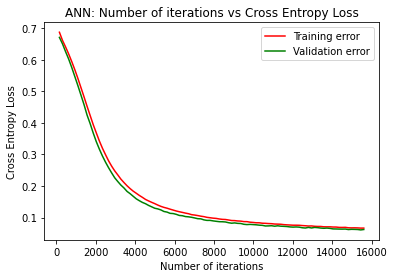

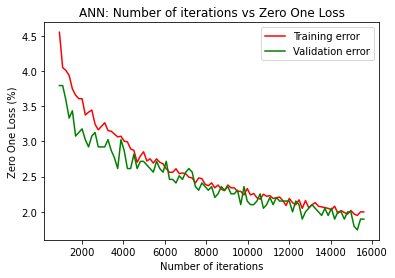

In [132]:
# visualize Cross Entropy loss 
plt.plot(iterations, training_loss, color = "red", label = "Training error")
plt.plot(iterations, validation_loss, color = "green", label = "Validation error")
plt.legend()
plt.xlabel("Number of iterations")
plt.ylabel("Cross Entropy Loss")
plt.title("ANN: Number of iterations vs Cross Entropy Loss")
plt.show()


# visualize Zero-one Loss
plt.plot(iterations[5:], train_zero_one[5:], color = "red", label = "Training error") 
plt.plot(iterations[5:], val_zero_one[5:], color = "green", label = "Validation error")
plt.legend()
plt.xlabel("Number of iterations")
plt.ylabel("Zero One Loss (%)")
plt.title("ANN: Number of iterations vs Zero One Loss")
plt.show()


# Predict Test Data

In [134]:
# Predicting Test Data
tot = crt = acc = test_loss = count = 0
test_loss = []
for features, labels in test_loader:
    output = model(features)
    test_loss.append(error(output, labels).data)
    predicted = torch.max(output.data, 1)[1]
    tot += len(labels)
    crt += (predicted == labels).sum()
    count += 1

#avg_loss = test_loss / count
acc = 100 * crt / float(tot)
print("Test error: {:.4f}   Test Accuracy: {:.3f} %".format(np.mean(test_loss), acc))

Test error: 0.0630   Test Accuracy: 98.089 %
